# **ROP Prediction for Offshore Drilling (Well 58-32 – Utah FORGE)**  

Offshore drilling operations require precise monitoring of key drilling parameters to ensure efficiency, safety, and cost-effectiveness. One of the most critical metrics in drilling optimization is the **Rate of Penetration (ROP)**, which indicates how quickly a drill bit advances through subsurface formations. This project leverages machine learning to develop a predictive model for ROP using diagnostic drilling data from **Well 58-32 (Utah FORGE)**. By providing accurate real-time predictions, this model assists drilling engineers in optimizing operations, detecting anomalies, and proactively managing maintenance.  

The dataset used in this study originates from **Utah FORGE**, a geothermal research project led by the **Idaho National Laboratory** in collaboration with the **Energy and Geoscience Institute at the University of Utah**. It includes **Pason log records collected at 1Hz and downsampled to ~0.3m (1 ft) intervals**. The data were acquired during **Phase 2B of the FORGE project**, with the goal of evaluating geothermal reservoir characteristics. The dataset includes key drilling parameters such as **ROP, weight on bit, pump pressure, rotary speed, temperature, and flow rate**, among others.  

## **Technical Approach & Machine Learning Logic**  

To develop an accurate ROP prediction model, a structured **machine learning pipeline** was implemented, consisting of data preprocessing, model training, optimization, and evaluation.  

In the **data preprocessing** stage, the raw dataset was cleaned by handling missing values through **median imputation** and selecting relevant features. To maintain consistency, only **metric system columns** were retained. Additionally, **feature scaling using RobustScaler** was applied to normalize numerical variables while being less sensitive to outliers. **RobustScaler** was chosen over other scaling methods like StandardScaler or MinMaxScaler because drilling data often contains extreme values and heavy-tailed distributions, particularly in parameters like **ROP and Pump Pressure**. Unlike StandardScaler, which can be significantly affected by outliers, **RobustScaler uses the median and interquartile range (IQR)**, making it more resistant to skewed distributions and ensuring stable feature scaling.  
## **Data Preprocessing & Feature Engineering**  

### **Handling Right-Skewed ROP Distribution**  
Initial exploration of the **ROP (1 m)** variable revealed a **right-skewed distribution**, meaning that most values were concentrated near zero, with a long tail of higher values. This skewness can negatively impact model performance by making it harder to detect patterns. To address this, a **log transformation (log1p)** was applied to normalize the ROP values, reducing extreme variations while maintaining relative differences.

### **Feature Engineering: Correlation Analysis & Selection**  
A **correlation matrix** was generated to analyze relationships between features and the target variable. The matrix revealed:
- **ROP (1 m) negatively correlates with depth (-0.79)**, suggesting that as depth increases, ROP tends to decrease.
- **Strong correlations between weight on bit, hookload, and pump pressure**, indicating interdependencies between drilling parameters.
- Features with high multicollinearity were carefully considered to avoid redundancy in model training.

To refine feature selection, **LASSO regression** was applied, which assigns importance scores to each feature. The most influential features for ROP prediction were:
- **Hookload (kg)**
- **Flow Out (%)**
- **Depth (m)**
- **Weight on Bit (kg)**
- **Pump Press (KPa)**
- **Flow In (liters/min)**
- Other minor contributors such as **H2S Cellar and Pit Total (m3)**.

By selecting the most relevant features, unnecessary noise was eliminated, leading to improved model interpretability and performance.

  
For **model training**, multiple regression models were evaluated to determine the best-performing approach for ROP prediction. The **RandomForestRegressor** was chosen due to its robustness in handling complex, non-linear relationships. The **ROP (1 m)** variable was set as the target, while multiple drilling parameters such as **Weight on Bit, Pump Pressure, Rotary Speed, and Flow Rate** served as input features. The dataset was split into **training (90%) and testing (10%)** subsets to ensure reliable performance evaluation, allowing the model to learn from a larger portion of the data while maintaining a sufficient test set for validation.

To assess the effectiveness of different models, a **side-by-side comparison** was conducted, where each model's predictions were evaluated against actual ROP values using key regression metrics:
- **Mean Squared Error (MSE)** – Measures the average squared difference between actual and predicted values.
- **Mean Absolute Error (MAE)** – Represents the average magnitude of prediction errors.
- **R² Score (coefficient of determination)** – Indicates how well the model explains variability in the target variable.

The results showed that the **RandomForestRegressor** outperformed other models in terms of predictive accuracy, achieving:
- **MSE:** *0.037*
- **MAE:** *0.107*
- **R² Score:** *0.919*

To further validate performance, a **scatter plot comparing predicted vs. actual ROP values** was generated. This visualization demonstrated a strong alignment between predicted and actual values, reinforcing the model’s reliability. Additionally, **residual analysis** was performed to examine prediction errors across different depths, aiding in the detection of potential anomalies.

The comparative analysis highlights how machine learning can be leveraged to enhance **drilling efficiency, reduce operational costs, and enable early anomaly detection** in offshore drilling operations.
  

## **Impact & Applications**  

This machine learning model has significant implications for **drilling optimization** by enabling real-time parameter adjustments, thereby reducing **downtime and operational costs**. Additionally, **anomaly detection** through residual analysis allows for the early identification of drill bit failures or abnormal drilling conditions, enhancing safety and efficiency. Beyond offshore drilling, the methodologies applied in this project can be adapted for **predictive maintenance and performance optimization** in various industrial settings, including power tooling applications.  

This study demonstrates how **data-driven approaches** can revolutionize the **drilling and geothermal energy industries**, offering smarter, more efficient solutions for subsurface resource extraction.  

## **Data Source & Acknowledgments**  

The dataset used in this project comes from the publicly available **Utah FORGE: Drilling Data for Student Competition** and is licensed under **CC (Creative Commons)**. The data authors are:  

- **Robert Podgorney** (Idaho National Laboratory)  
- **John McLennan** (Energy and Geoscience Institute at the University of Utah)  
- **Joe Moore** (Energy and Geoscience Institute at the University of Utah)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Step 1: Load & Clean the Dataset
# --------------------------------------------------
data_path = 'Well_58-32_processed_pason_log.csv'
df = pd.read_csv(data_path)
pd.set_option('display.max_columns', None)
df.head()

,Depth(ft),Depth(m),ROP(1 ft),ROP(1 m),weight on bit (k-lbs),weight on bit (kg),Temp Out( degF),Temp Out( degC),Temp In(degF),Temp In(degC),Pit Total (bbls),Pit Total (m3),Pump Press (psi),Pump Press (KPa),Hookload (k-lbs),Hookload (kg),Surface Torque (psi),Surface Torque (KPa),Rotary Speed (rpm),Flow In (gal/min),Flow In(liters/min),Flow Out %,WH Pressure (psi),WH Pressure (KPa),H2S Floor,H2S Cellar,H2S Pits
0,85.18,25.96,56.80,17.31,0.0,0.0,93.49,34.16,90.87,32.71,274.83,43.69,463.72,3197.35,31.77,14408.16,8.93,61.57,151.09,1109.58,4200.22,101.61,-1230.69,-8485.61,-0.01,-0.03,0.31
1,86.18,26.27,61.14,18.63,0.0,0.0,93.52,34.18,90.83,32.68,274.83,43.69,459.53,3168.46,31.01,14063.49,8.93,61.57,151.09,1108.36,4195.60,101.70,-1230.69,-8485.61,-0.01,-0.04,0.31
2,87.23,26.59,18.58,5.66,0.0,0.0,94.25,34.58,90.91,32.73,273.80,43.53,454.57,3134.26,31.01,14063.49,9.01,62.12,61.54,1102.87,4174.82,96.81,-1230.69,-8485.61,-0.01,-0.03,0.30
3,88.26,26.90,38.29,11.67,0.0,0.0,94.44,34.69,91.14,32.86,273.79,43.53,451.14,3110.61,31.16,14131.52,8.97,61.85,60.23,1101.04,4167.89,96.67,-1230.69,-8485.61,0.00,-0.03,0.31
4,89.36,27.24,394.38,120.20,0.0,0.0,94.48,34.71,91.18,32.88,273.80,43.53,456.09,3144.74,31.54,14303.85,8.97,61.85,61.75,1102.46,4173.26,96.63,-1230.69,-8485.61,-0.02,-0.02,0.31


In [3]:
# taking out the column names
df.columns

Index(['Depth(ft)', 'Depth(m)', 'ROP(1 ft)', 'ROP(1 m)',
       'weight on bit (k-lbs)', 'weight on bit (kg)', 'Temp Out( degF)',
       'Temp Out( degC)', 'Temp In(degF)', 'Temp In(degC)', 'Pit Total (bbls)',
       'Pit Total (m3)', 'Pump Press (psi)', 'Pump Press (KPa)',
       'Hookload (k-lbs)', 'Hookload (kg)', 'Surface Torque (psi)',
       'Surface Torque (KPa)', 'Rotary Speed (rpm)', 'Flow In (gal/min)',
       'Flow In(liters/min)', 'Flow Out %', 'WH Pressure (psi)',
       'WH Pressure (KPa)', 'H2S Floor', 'H2S Cellar', 'H2S Pits'],
      dtype='object')

In [4]:
# Define a list of metric columns to keep
# same in metric and imperial
# percentage, remains unchanged
# assume these H2S columns are consistent
metric_columns = [
    'Depth(m)',
    'ROP(1 m)',
    'weight on bit (kg)',
    'Temp Out( degC)',
    'Temp In(degC)',
    'Pit Total (m3)',
    'Pump Press (KPa)',
    'Hookload (kg)',
    'Surface Torque (KPa)',
    'Rotary Speed (rpm)',      
    'Flow In(liters/min)',
    'Flow Out %',              
    'WH Pressure (KPa)',
    'H2S Floor',               
    'H2S Cellar',
    'H2S Pits'
]

In [5]:
df_metric = df[metric_columns]

# Display the first few rows to verify
df_metric.head()

,Depth(m),ROP(1 m),weight on bit (kg),Temp Out( degC),Temp In(degC),Pit Total (m3),Pump Press (KPa),Hookload (kg),Surface Torque (KPa),Rotary Speed (rpm),Flow In(liters/min),Flow Out %,WH Pressure (KPa),H2S Floor,H2S Cellar,H2S Pits
0,25.96,17.31,0.0,34.16,32.71,43.69,3197.35,14408.16,61.57,151.09,4200.22,101.61,-8485.61,-0.01,-0.03,0.31
1,26.27,18.63,0.0,34.18,32.68,43.69,3168.46,14063.49,61.57,151.09,4195.60,101.70,-8485.61,-0.01,-0.04,0.31
2,26.59,5.66,0.0,34.58,32.73,43.53,3134.26,14063.49,62.12,61.54,4174.82,96.81,-8485.61,-0.01,-0.03,0.30
3,26.90,11.67,0.0,34.69,32.86,43.53,3110.61,14131.52,61.85,60.23,4167.89,96.67,-8485.61,0.00,-0.03,0.31
4,27.24,120.20,0.0,34.71,32.88,43.53,3144.74,14303.85,61.85,61.75,4173.26,96.63,-8485.61,-0.02,-0.02,0.31


In [6]:
df_metric.count()

Depth(m)                7311
ROP(1 m)                7311
weight on bit (kg)      7311
Temp Out( degC)         7311
Temp In(degC)           7311
Pit Total (m3)          7311
Pump Press (KPa)        7311
Hookload (kg)           7311
Surface Torque (KPa)    7311
Rotary Speed (rpm)      7311
Flow In(liters/min)     7311
Flow Out %              7311
WH Pressure (KPa)       7311
H2S Floor               7311
H2S Cellar              7311
H2S Pits                7311
dtype: int64

In [7]:
# Check data types
print(df_metric.dtypes)

# Check and remove duplicates
duplicate_count = df_metric.duplicated().sum()
print("Number of duplicates:", duplicate_count)
df_metric = df_metric.drop_duplicates()


Depth(m)                float64
ROP(1 m)                float64
weight on bit (kg)      float64
Temp Out( degC)         float64
Temp In(degC)           float64
Pit Total (m3)          float64
Pump Press (KPa)        float64
Hookload (kg)           float64
Surface Torque (KPa)    float64
Rotary Speed (rpm)      float64
Flow In(liters/min)     float64
Flow Out %              float64
WH Pressure (KPa)       float64
H2S Floor               float64
H2S Cellar              float64
H2S Pits                float64
dtype: object
Number of duplicates: 30


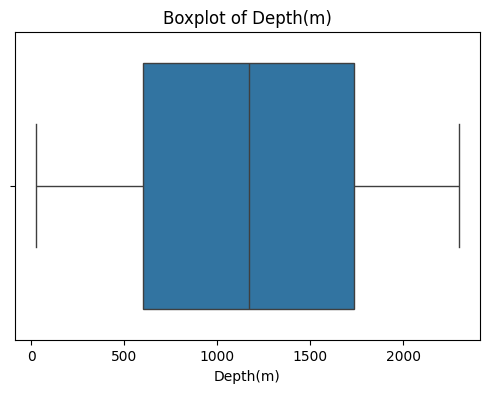

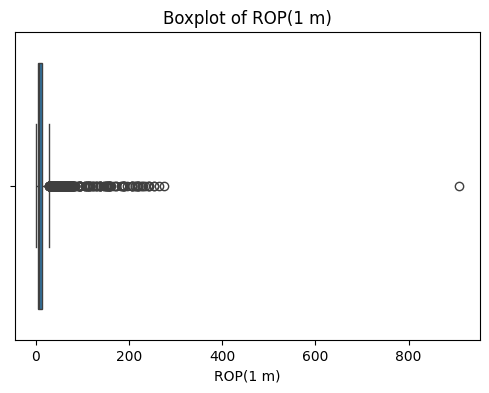

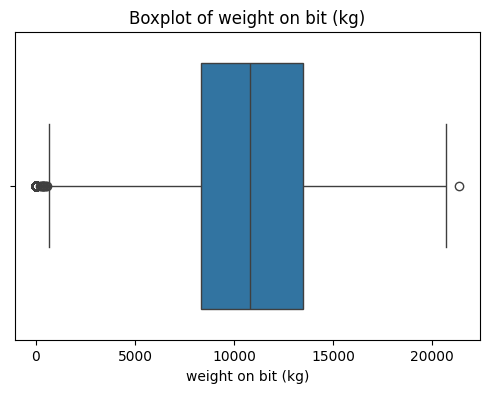

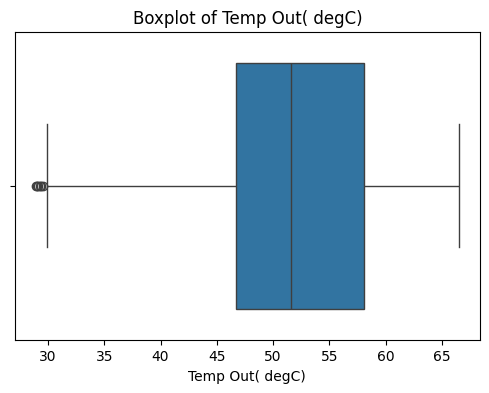

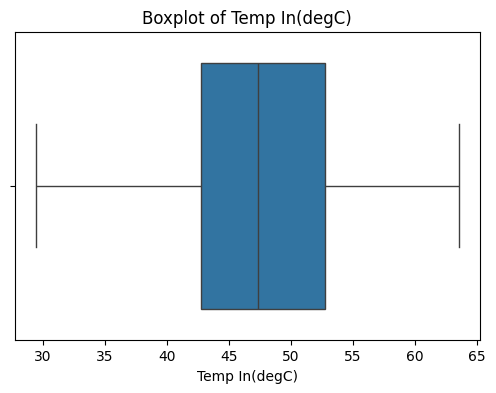

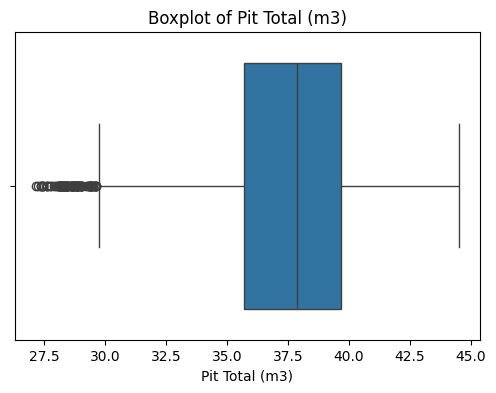

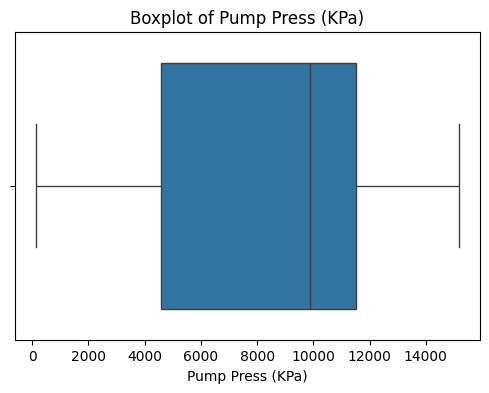

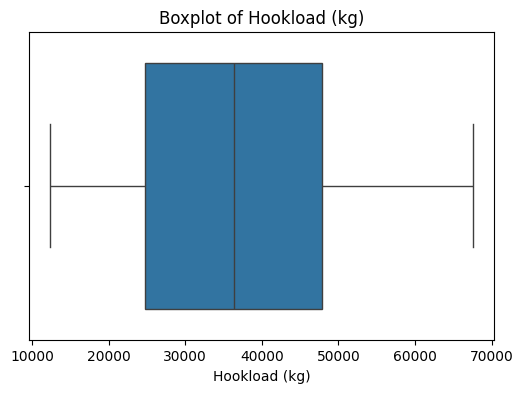

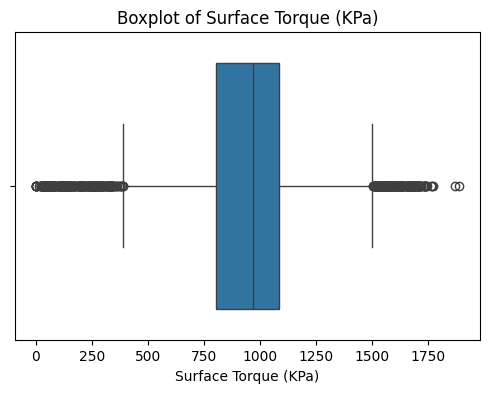

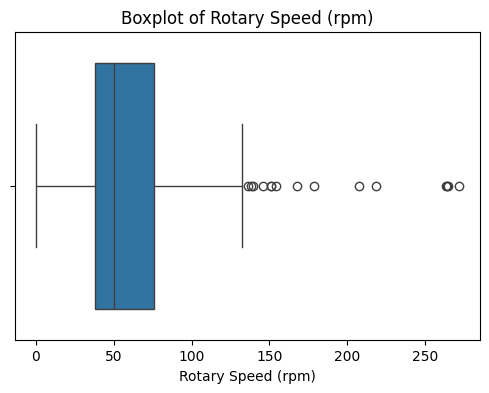

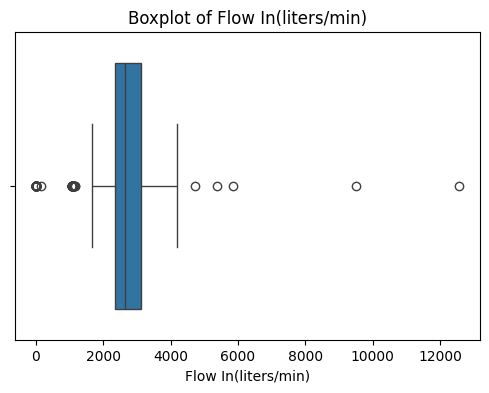

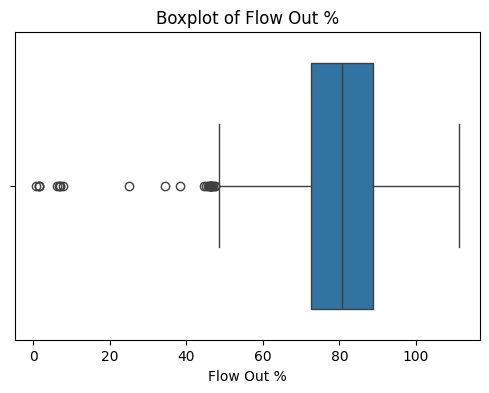

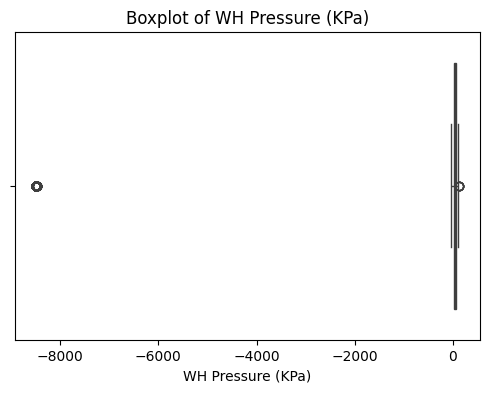

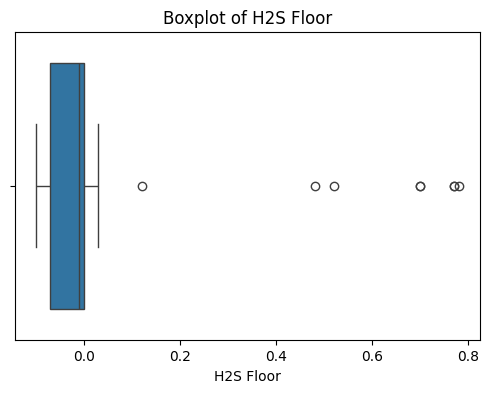

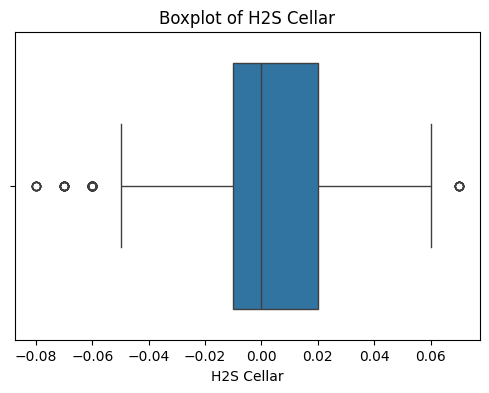

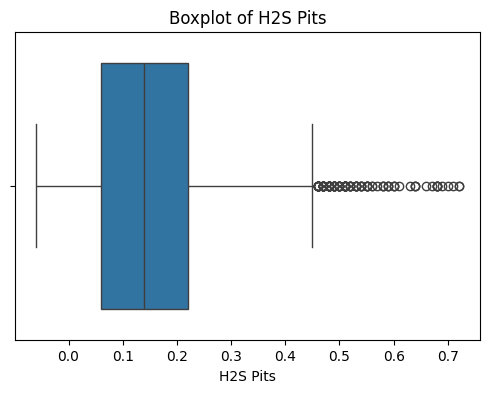

In [8]:
# Visualize boxplots for each numerical column
for col in df_metric.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_metric[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


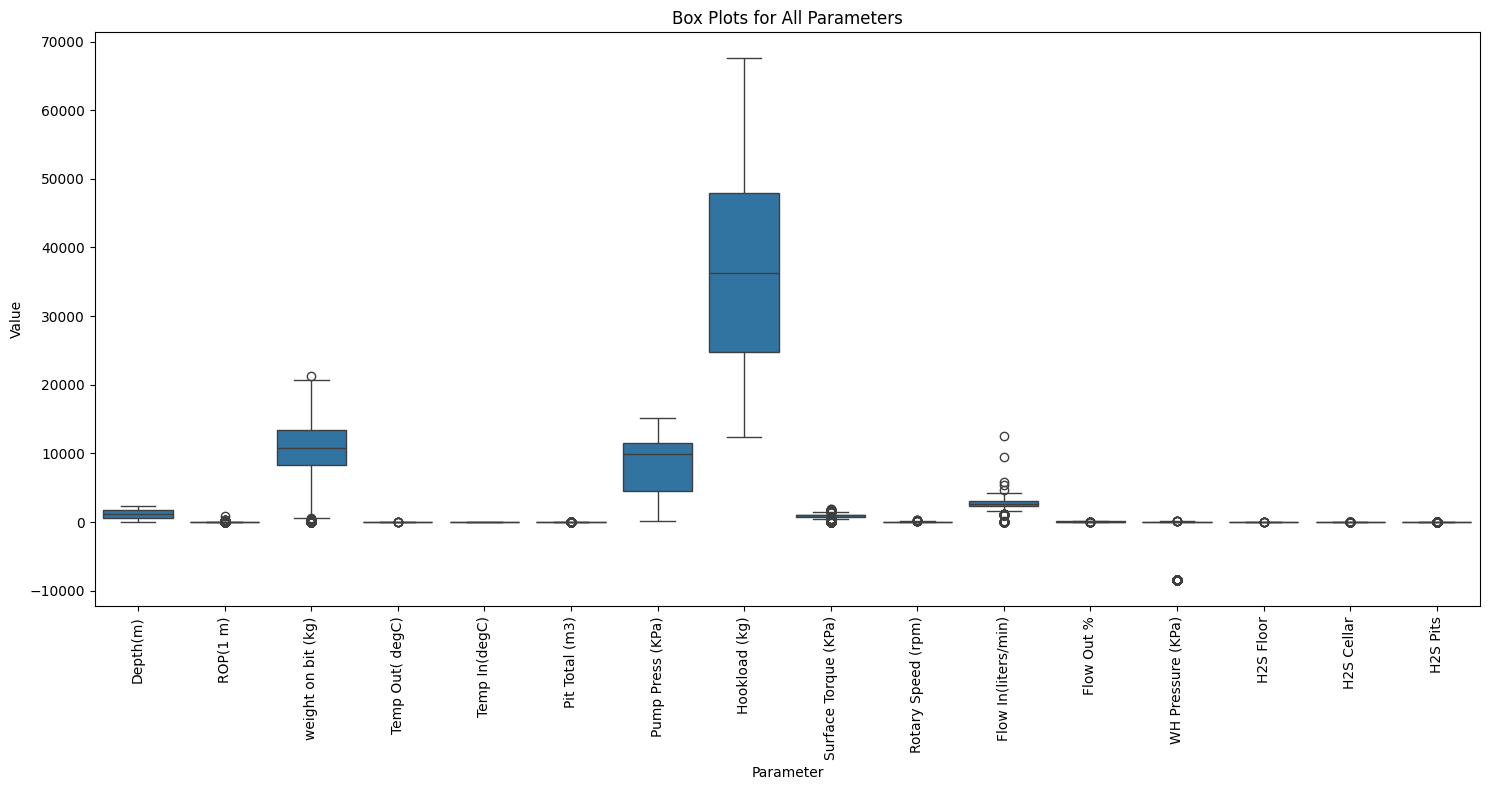

In [9]:
import seaborn as sns

# df_metric is the DataFrame containing the metric columns

metric_columns = [
    'Depth(m)', 'ROP(1 m)', 'weight on bit (kg)', 'Temp Out( degC)',
    'Temp In(degC)', 'Pit Total (m3)', 'Pump Press (KPa)', 'Hookload (kg)',
    'Surface Torque (KPa)', 'Rotary Speed (rpm)', 'Flow In(liters/min)',
    'Flow Out %', 'WH Pressure (KPa)', 'H2S Floor', 'H2S Cellar', 'H2S Pits'
]

df_metric = df[metric_columns]

# Melt the DataFrame so each parameter is in one column
df_melted = df_metric.melt(var_name='Parameter', value_name='Value')

# Plot the box plots using Seaborn
plt.figure(figsize=(15, 8))
sns.boxplot(x='Parameter', y='Value', data=df_melted)
plt.xticks(rotation=90)
plt.title('Box Plots for All Parameters')
plt.tight_layout()
plt.show()


## Viewing the plots without the outliers for clearity (keeping in mind that we have outliers in the dataset)

C:\Users\hrish\AppData\Local\Temp\ipykernel_42768\3012802473.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


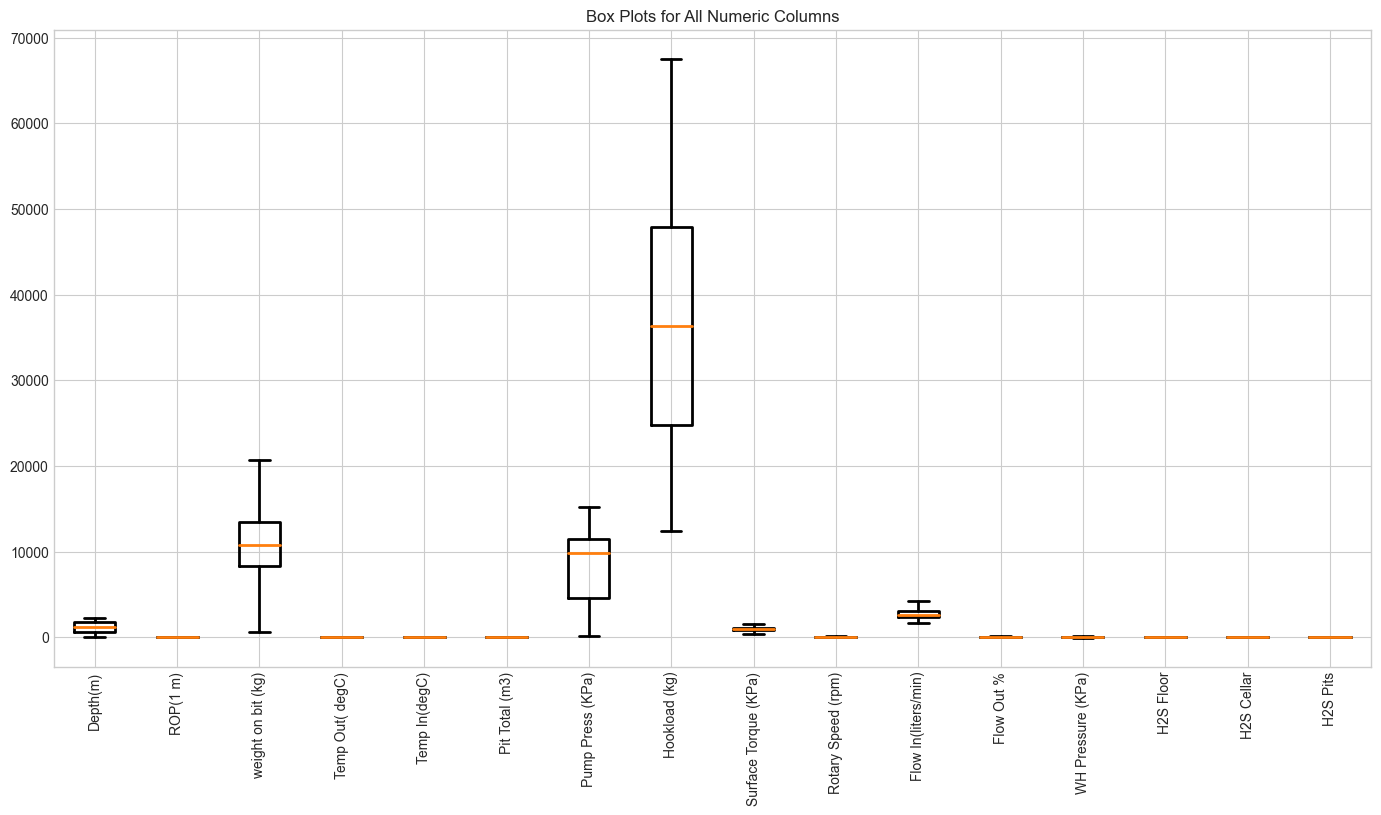

In [10]:


# Use DataFrame with numeric columns
df_box = df_metric.select_dtypes(include=[np.number])

plt.style.use('seaborn-whitegrid')

ax = df_box.plot(
    kind='box',
    color=dict(boxes='r', whiskers='royalblue', medians='gray', caps='gray'),
    boxprops=dict(linestyle='-', linewidth=2),
    flierprops=dict(linestyle='-', linewidth=2),
    medianprops=dict(linestyle='-', linewidth=2),
    whiskerprops=dict(linestyle='-', linewidth=2),
    capprops=dict(linestyle='-', linewidth=2),
    showfliers=False,   # hides individual outlier points
    grid=True,
    rot=0,
    figsize=(17, 8.27)
)

# Rotate x-axis 
plt.xticks(rotation=90)

# Increase font size for ticks
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)

# Add a title or labels
plt.title('Box Plots for All Numeric Columns')

# Save the plot to a file
plt.savefig('plot_box.pdf', bbox_inches='tight')

# Display the plot
plt.show()


### Applying Scaling technique using RobustScaler as it performs the best in scaling when data set contains a lot of outliers. Since, it's not clear if the outliers are needed to be removed or not applying robust scaling was the best option.

In [11]:
from sklearn.preprocessing import RobustScaler  # Ensure importing of the correct scaler

# Selecting only numeric columns (assuming df_metric already contains metric columns)
numeric_cols = df_metric.select_dtypes(include=['float64', 'int64']).columns

scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_metric[numeric_cols])
df_scaled = pd.DataFrame(scaled_data, columns=numeric_cols)

# Checking the summary statistics of the scaled data (mean ~ 0, std ~ 1)
print(df_scaled.describe().loc[['mean', 'std']])

      Depth(m)  ROP(1 m)  weight on bit (kg)  Temp Out( degC)  Temp In(degC)  \
mean -0.004519  0.730225           -0.062736         0.058824       0.061278   
std   0.577101  2.307041            0.802065         0.602212       0.662617   

      Pit Total (m3)  Pump Press (KPa)  Hookload (kg)  Surface Torque (KPa)  \
mean       -0.048065         -0.165249       0.022502             -0.231543   
std         0.729498          0.488556       0.520602              1.209183   

      Rotary Speed (rpm)  Flow In(liters/min)  Flow Out %  WH Pressure (KPa)  \
mean            0.120589             0.078516   -0.062807          -7.809106   
std             0.685087             0.693833    0.735375          41.697625   

      H2S Floor  H2S Cellar  H2S Pits  
mean  -0.248178    0.143437  0.055208  
std    0.606470    0.842717  0.720561  


In [12]:
df_scaled = df_scaled.round(2)
df_scaled.head()

,Depth(m),ROP(1 m),weight on bit (kg),Temp Out( degC),Temp In(degC),Pit Total (m3),Pump Press (KPa),Hookload (kg),Surface Torque (KPa),Rotary Speed (rpm),Flow In(liters/min),Flow Out %,WH Pressure (KPa),H2S Floor,H2S Cellar,H2S Pits
0,-1.01,1.18,-2.1,-1.54,-1.46,1.46,-0.96,-0.95,-3.26,2.66,2.00,1.29,-231.57,0.00,-1.00,1.06
1,-1.01,1.31,-2.1,-1.54,-1.47,1.46,-0.97,-0.97,-3.26,2.66,2.00,1.30,-231.57,0.00,-1.33,1.06
2,-1.01,0.02,-2.1,-1.50,-1.46,1.42,-0.97,-0.97,-3.26,0.29,1.97,0.99,-231.57,0.00,-1.00,1.00
3,-1.01,0.62,-2.1,-1.49,-1.45,1.42,-0.98,-0.96,-3.26,0.26,1.96,0.99,-231.57,0.14,-1.00,1.06
4,-1.01,11.44,-2.1,-1.49,-1.45,1.42,-0.97,-0.95,-3.26,0.30,1.97,0.98,-231.57,-0.14,-0.67,1.06


In [13]:
df_scaled.describe()

,Depth(m),ROP(1 m),weight on bit (kg),Temp Out( degC),Temp In(degC),Pit Total (m3),Pump Press (KPa),Hookload (kg),Surface Torque (KPa),Rotary Speed (rpm),Flow In(liters/min),Flow Out %,WH Pressure (KPa),H2S Floor,H2S Cellar,H2S Pits
count,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000
mean,-0.004514,0.730137,-0.062896,0.058925,0.061149,-0.047998,-0.165211,0.022435,-0.231555,0.120577,0.078482,-0.062719,-7.809421,-0.248848,0.143359,0.054917
std,0.577112,2.306950,0.802328,0.602256,0.662513,0.729549,0.488559,0.520642,1.209210,0.685025,0.693972,0.735428,41.697961,0.607006,0.842600,0.720655
min,-1.010000,-0.550000,-2.100000,-2.000000,-1.790000,-2.690000,-1.410000,-1.040000,-3.480000,-1.330000,-3.430000,-4.940000,-231.790000,-1.290000,-2.670000,-1.250000
25%,-0.510000,-0.200000,-0.490000,-0.430000,-0.465000,-0.540000,-0.760000,-0.500000,-0.580000,-0.320000,-0.390000,-0.500000,-0.570000,-0.860000,-0.330000,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.490000,0.800000,0.510000,0.570000,0.540000,0.460000,0.240000,0.500000,0.420000,0.680000,0.610000,0.500000,0.430000,0.140000,0.670000,0.500000
max,0.990000,89.940000,2.040000,1.320000,1.620000,1.670000,0.760000,1.350000,3.310000,5.840000,12.810000,1.880000,2.150000,11.290000,2.330000,3.620000


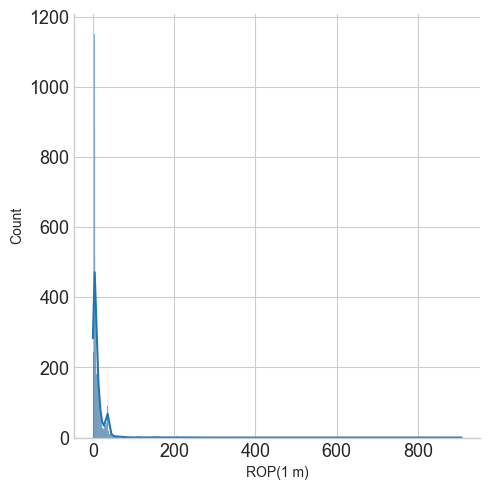

In [14]:
column_name = df_scaled['ROP(1 m)']  # Replace with column name
sns.displot(df['ROP(1 m)'], kde=True)  # kde=True adds a Kernel Density Estimate curve
plt.show()

C:\Users\hrish\AppData\Local\Temp\ipykernel_42768\3985786245.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


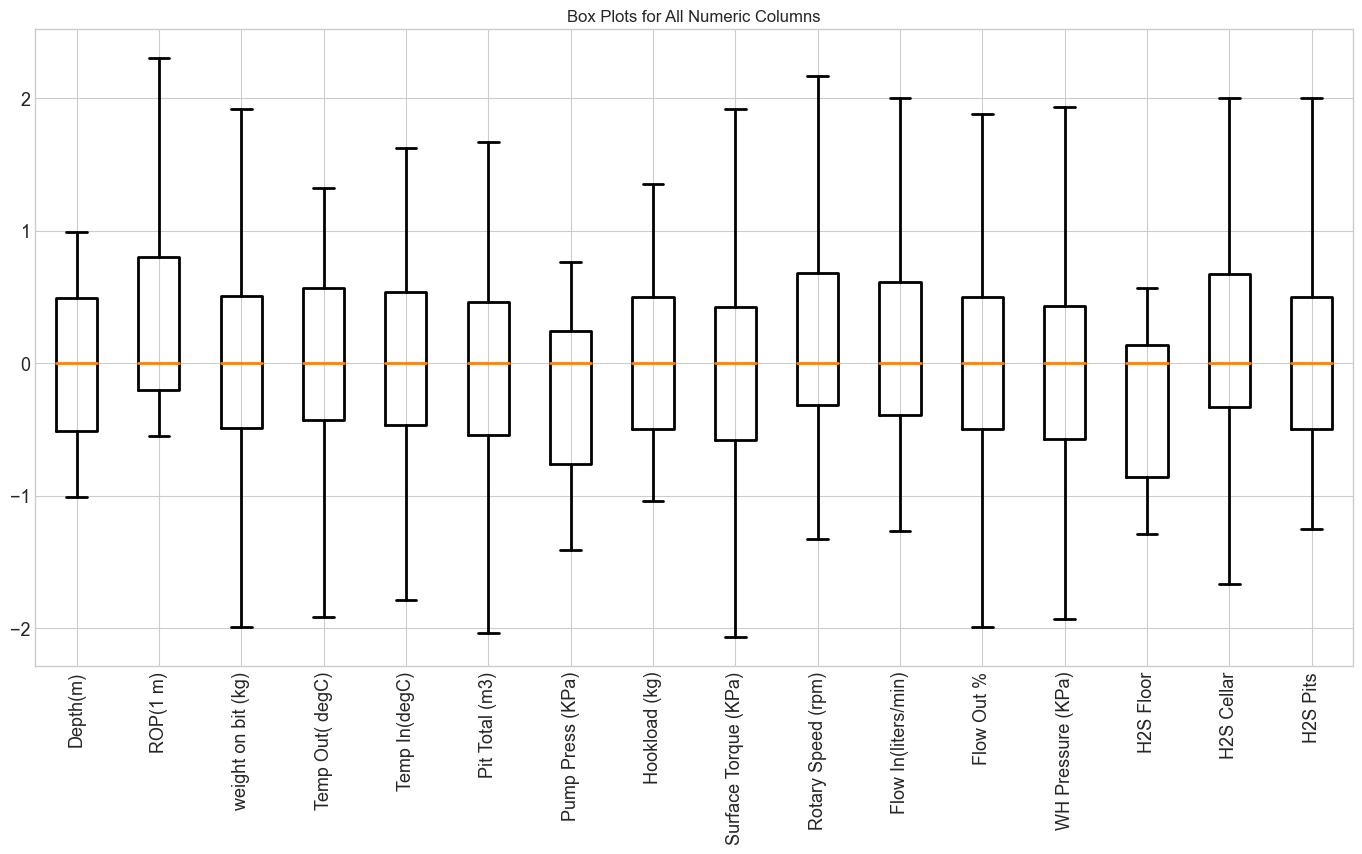

In [15]:


# Now use the DataFrame with numeric columns
# e.g., df_metric is already filtered to only numeric or metric columns.
df_box_scaled = df_scaled.select_dtypes(include=[np.number])

plt.style.use('seaborn-whitegrid')

ax = df_box_scaled.plot(
    kind='box',
    color=dict(boxes='r', whiskers='royalblue', medians='gray', caps='gray'),
    boxprops=dict(linestyle='-', linewidth=2),
    flierprops=dict(linestyle='-', linewidth=2),
    medianprops=dict(linestyle='-', linewidth=2),
    whiskerprops=dict(linestyle='-', linewidth=2),
    capprops=dict(linestyle='-', linewidth=2),
    showfliers=False,   
    grid=True,
    rot=0,
    figsize=(17, 8.27)
)

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Increase font size for ticks
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)

# Add a title or labels if desired
plt.title('Box Plots for All Numeric Columns')

# Save the plot to a file
plt.savefig('plot_box.pdf', bbox_inches='tight')

# Display the plot
plt.show()


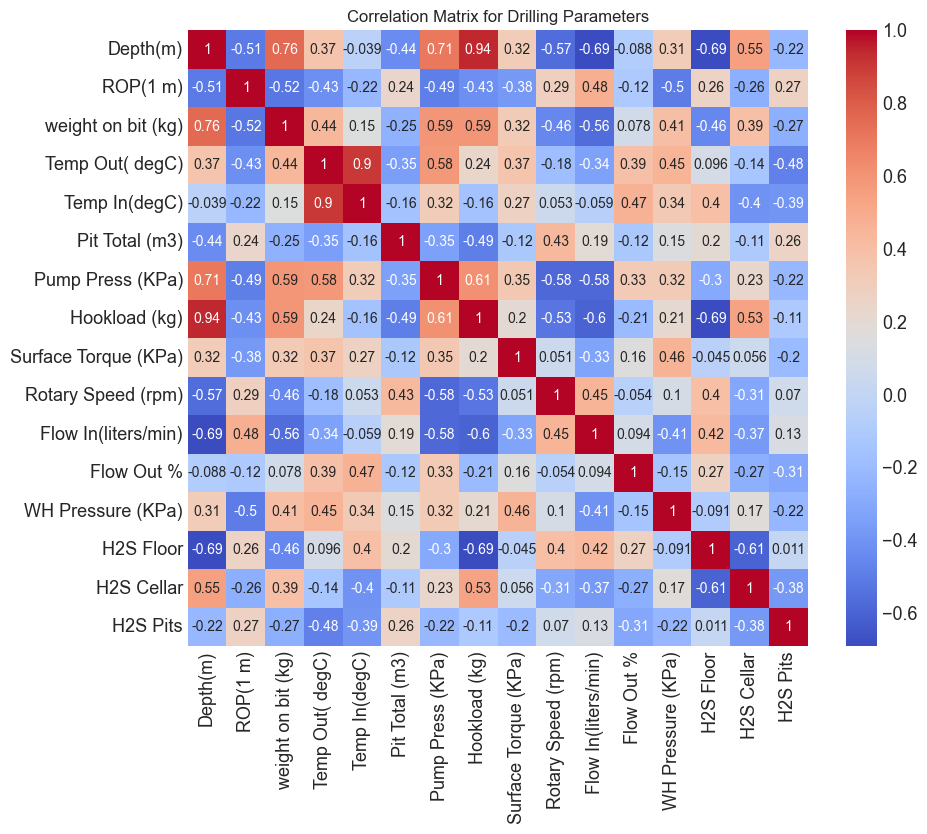

In [16]:

# Calculating the correlation matrix on the original (or scaled) metric data
corr_matrix = df_scaled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Drilling Parameters')
plt.show()


### Checking data distribution of ROP

In [17]:
skew_value = df_scaled['ROP(1 m)'].skew()
print(f"Skewness of ROP(1 m): {skew_value}")


Skewness of ROP(1 m): 12.151741275268169


#### Here, we can see that the data is right skewed. Hence, to remove this i'm going through the path of log transformation. 

In [18]:
df_scaled['ROP(1 m)'] = np.log1p(df_scaled['ROP(1 m)'])

#### plotting the box plot and correrlation matrix again

In [19]:
df_scaled.describe()

,Depth(m),ROP(1 m),weight on bit (kg),Temp Out( degC),Temp In(degC),Pit Total (m3),Pump Press (KPa),Hookload (kg),Surface Torque (KPa),Rotary Speed (rpm),Flow In(liters/min),Flow Out %,WH Pressure (KPa),H2S Floor,H2S Cellar,H2S Pits
count,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000
mean,-0.004514,0.255954,-0.062896,0.058925,0.061149,-0.047998,-0.165211,0.022435,-0.231555,0.120577,0.078482,-0.062719,-7.809421,-0.248848,0.143359,0.054917
std,0.577112,0.654623,0.802328,0.602256,0.662513,0.729549,0.488559,0.520642,1.209210,0.685025,0.693972,0.735428,41.697961,0.607006,0.842600,0.720655
min,-1.010000,-0.798508,-2.100000,-2.000000,-1.790000,-2.690000,-1.410000,-1.040000,-3.480000,-1.330000,-3.430000,-4.940000,-231.790000,-1.290000,-2.670000,-1.250000
25%,-0.510000,-0.223144,-0.490000,-0.430000,-0.465000,-0.540000,-0.760000,-0.500000,-0.580000,-0.320000,-0.390000,-0.500000,-0.570000,-0.860000,-0.330000,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.490000,0.587787,0.510000,0.570000,0.540000,0.460000,0.240000,0.500000,0.420000,0.680000,0.610000,0.500000,0.430000,0.140000,0.670000,0.500000
max,0.990000,4.510200,2.040000,1.320000,1.620000,1.670000,0.760000,1.350000,3.310000,5.840000,12.810000,1.880000,2.150000,11.290000,2.330000,3.620000


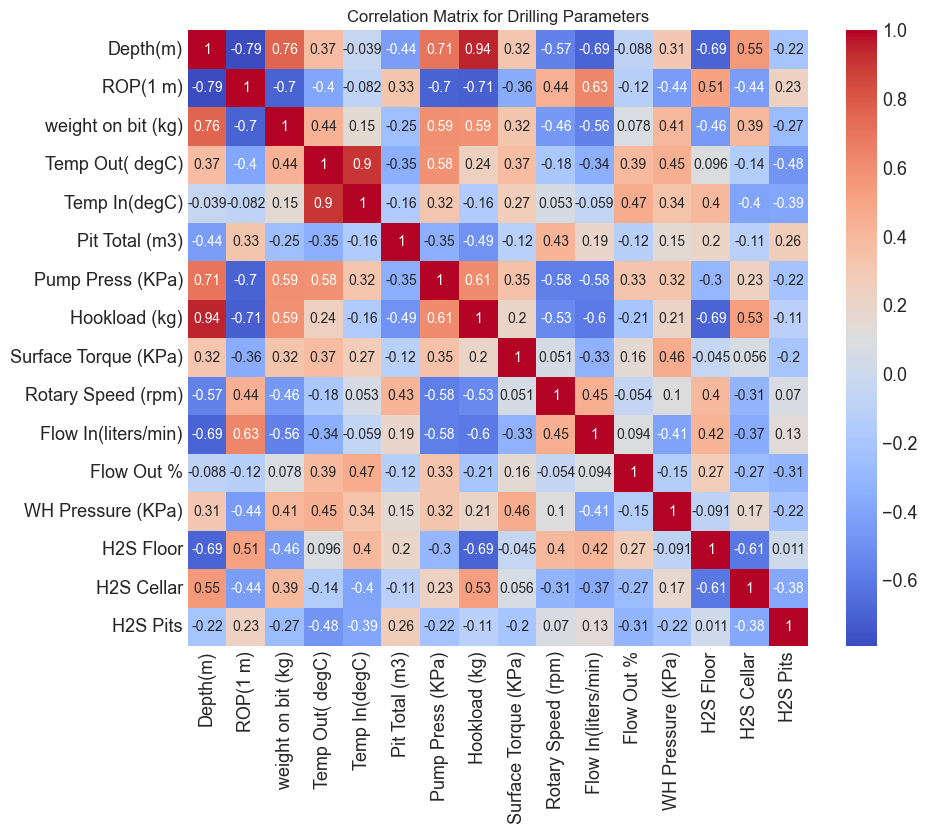

In [20]:
# Now. Calculating the correlation matrix on the original (or scaled) metric data
corr_matrix = df_scaled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Drilling Parameters')
plt.show()

---

In [21]:
# # Handling outliers using IQR method
# def remove_outliers(df, columns):
#     df_clean = df.copy()
#     for col in columns:
#         Q1 = df_clean[col].quantile(0.25)
#         Q3 = df_clean[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
#     return df_clean

# # Apply to numerical columns except target variable
# numerical_columns = df_scaled.select_dtypes(include=['float64', 'int64']).columns
# columns_to_clean = [col for col in numerical_columns if col != 'ROP(1 m)']
# df_cleaned = remove_outliers(df_scaled, columns_to_clean)

In [22]:
# # Add interaction features
# df_cleaned['WOB_RPM'] = df_cleaned['weight on bit (kg)'] * df_cleaned['Rotary Speed (rpm)']
# df_cleaned['Torque_RPM'] = df_cleaned['Surface Torque (KPa)'] * df_cleaned['Rotary Speed (rpm)']
# df_cleaned['MSE'] = (df_cleaned['weight on bit (kg)'] / 1000) + (120 * np.pi * df_cleaned['Surface Torque (KPa)'] * df_cleaned['Rotary Speed (rpm)']) / (df_cleaned['ROP(1 m)'] * 1000)

# # Add rolling statistics
# df_cleaned['ROP_rolling_mean'] = df_cleaned['ROP(1 m)'].rolling(window=5, min_periods=1).mean()
# df_cleaned['WOB_rolling_std'] = df_cleaned['weight on bit (kg)'].rolling(window=5, min_periods=1).std()

In [23]:
# df_cleaned.dropna()
# df_cleaned.head()

In [24]:
# df_cleaned = df_cleaned.dropna()
# print("Shape after removing NaN values:", df_cleaned.shape)
# print("\nNumber of NaN values in each column:")
# print(df_cleaned.isna().sum())

In [25]:
df_scaled.shape

(7311, 16)

In [26]:
print("\nNumber of NaN values in each column:")
print(df_scaled.isna().sum())


Number of NaN values in each column:
Depth(m)                0
ROP(1 m)                0
weight on bit (kg)      0
Temp Out( degC)         0
Temp In(degC)           0
Pit Total (m3)          0
Pump Press (KPa)        0
Hookload (kg)           0
Surface Torque (KPa)    0
Rotary Speed (rpm)      0
Flow In(liters/min)     0
Flow Out %              0
WH Pressure (KPa)       0
H2S Floor               0
H2S Cellar              0
H2S Pits                0
dtype: int64


# Feature selection

In [27]:
def check_and_clean_data(df):
    # this is to check for infinite values
    inf_cols = df.columns[np.isinf(df).any()].tolist()
    print("Columns with infinite values:", inf_cols)
    
    # Replace infinite values with NaN
    df_clean = df.replace([np.inf, -np.inf], np.nan)
    
    # Handle NaN values by filling with median
    df_clean = df_clean.fillna(df_clean.median())
    
    return df_clean

In [28]:
# separate features (X) and target (y)
X = df_scaled.drop('ROP(1 m)', axis=1)
y = df_scaled['ROP(1 m)']

# clean the feature DataFrame
X_cleaned = check_and_clean_data(X)

Columns with infinite values: []


In [29]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Initializing Lasso (adjust alpha as needed)
lasso = Lasso(alpha=0.01, random_state=42)
# Create a SelectFromModel object using Lasso
selector = SelectFromModel(lasso, prefit=False)
# Fit the selector to the scaled data and target
selector.fit(X_cleaned, y)
# Transform the data to include only selected features
X_selected = selector.transform(X_cleaned)
# Getting the names of selected features
selected_features = X_cleaned.columns[selector.get_support()].tolist()

print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")


Selected features:
- Depth(m)
- weight on bit (kg)
- Temp In(degC)
- Pit Total (m3)
- Pump Press (KPa)
- Hookload (kg)
- Rotary Speed (rpm)
- Flow In(liters/min)
- Flow Out %
- WH Pressure (KPa)
- H2S Floor
- H2S Cellar
- H2S Pits



Feature importances (absolute Lasso coefficients):
                 Feature  Importance
6          Hookload (kg)    0.317750
10            Flow Out %    0.221182
0               Depth(m)    0.155090
1     weight on bit (kg)    0.117653
5       Pump Press (KPa)    0.097750
9    Flow In(liters/min)    0.083701
13            H2S Cellar    0.070876
12             H2S Floor    0.054950
4         Pit Total (m3)    0.045007
14              H2S Pits    0.041343
3          Temp In(degC)    0.041073
8     Rotary Speed (rpm)    0.006888
11     WH Pressure (KPa)    0.004364
2        Temp Out( degC)    0.000000
7   Surface Torque (KPa)    0.000000


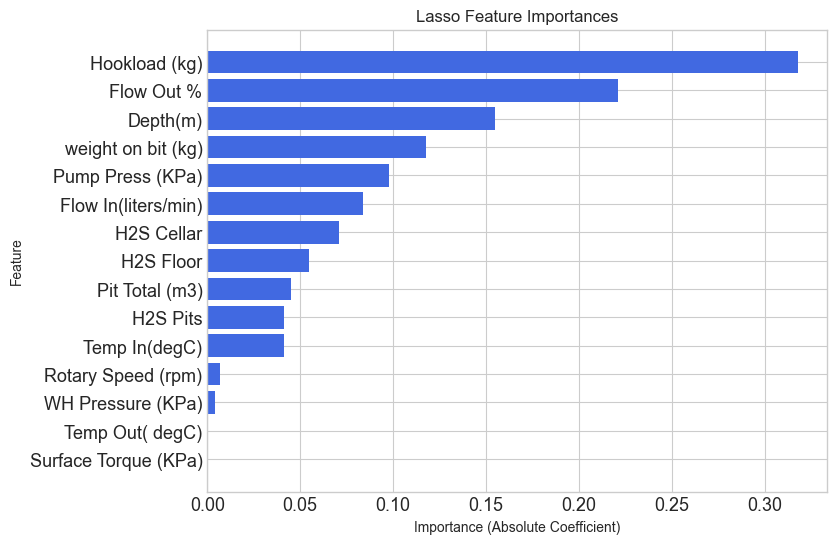

In [30]:
importances = np.abs(selector.estimator_.coef_)
feature_importance_df = pd.DataFrame({
    'Feature': X_cleaned.columns,
    'Importance': importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print("\nFeature importances (absolute Lasso coefficients):")
print(feature_importance_df)
# Optional: Plot the feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.gca().invert_yaxis()  # so the top feature is at the top
plt.title("Lasso Feature Importances")
plt.xlabel("Importance (Absolute Coefficient)")
plt.ylabel("Feature")
plt.show()


In [31]:
X.shape

(7311, 15)

## Splitting the data and model building approach - SUPERVISED LEARNING APPROACH

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, 
    y, 
    test_size=0.1,
    random_state=42
)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (6579, 15)
Test set size: (732, 15)


In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# -------------------------------------------
# 2. Define Models and Parameter Grids
# -------------------------------------------

models = {
    'RandomForest': (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5]
        }
    ),
    'SVR': (
        SVR(),
        {
            'kernel': ['rbf', 'linear'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    )
}

# -------------------------------------------
# 3. K-fold Cross Validation Setup
# -------------------------------------------

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------------------------
# 4. GridSearchCV for Each Model
# -------------------------------------------

results = []  # to store (model_name, best_estimator, best_params, best_cv_score)

for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
        cv=cv,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    best_est = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_  # negate because of 'neg_mean_squared_error'
    
    results.append((model_name, best_est, best_params, best_score))

# Sort results by best CV MSE (ascending)
results.sort(key=lambda x: x[3])

# Display the outcomes
print("Model comparison results (sorted by CV MSE):")
for model_name, best_est, best_params, best_score in results:
    print(f"\nModel: {model_name}")
    print(f"  Best Params: {best_params}")
    print(f"  Best CV MSE: {best_score:.3f}")


Model comparison results (sorted by CV MSE):

Model: RandomForest
  Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
  Best CV MSE: 0.034

Model: SVR
  Best Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
  Best CV MSE: 0.043


In [34]:
# After for-loop for model_name, (model, param_grid) in models.items(): to get the best parameters
print("DEBUG: Contents of 'results':")
for i, item in enumerate(results):
    print(f"Item {i} => {item}")


DEBUG: Contents of 'results':
Item 0 => ('RandomForest', RandomForestRegressor(random_state=42), {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}, 0.03356176818967521)
Item 1 => ('SVR', SVR(C=10, gamma='auto'), {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}, 0.0428427302899919)



Test Set Performance:

Model: RandomForest
  MSE: 0.032
  MAE: 0.106
  R^2: 0.928

Model: SVR
  MSE: 0.044
  MAE: 0.127
  R^2: 0.902


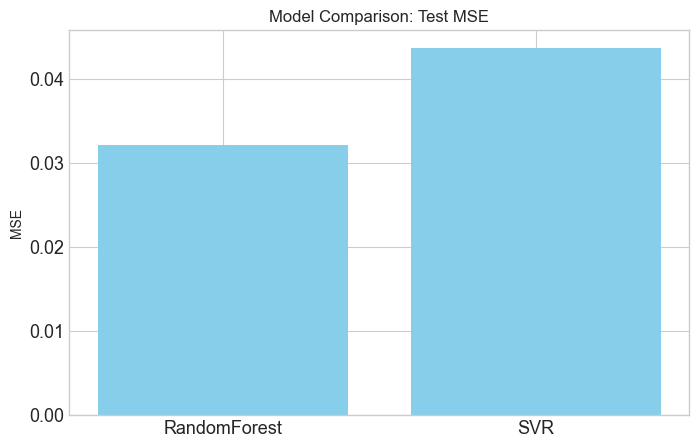

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# We'll evaluate each model on the unseen test set
test_results = []  # to store (model_name, test_mse, test_mae, test_r2)

for model_name, best_est, _, _ in results:
    # Predict on the test set
    y_pred = best_est.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    
    test_results.append((model_name, mse, mae, r2))

# Display results in a table-like format
print("\nTest Set Performance:")
for model_name, mse, mae, r2 in test_results:
    print(f"\nModel: {model_name}")
    print(f"  MSE: {mse:.3f}")
    print(f"  MAE: {mae:.3f}")
    print(f"  R^2: {r2:.3f}")

# Optional: Bar plot of test MSE for each model
model_names = [r[0] for r in test_results]
mse_scores  = [r[1] for r in test_results]

plt.figure(figsize=(8, 5))
plt.bar(model_names, mse_scores, color='skyblue')
plt.title("Model Comparison: Test MSE")
plt.ylabel("MSE")
plt.show()


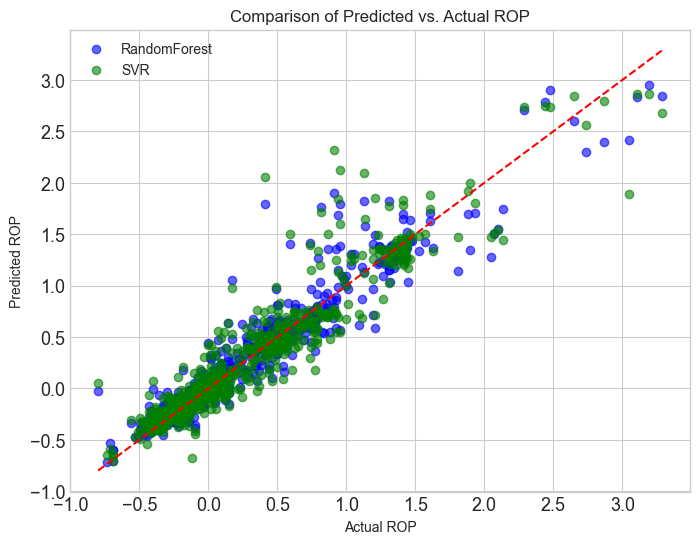

In [36]:

predictions_dict = {}  # to store y_pred for each model

for model_name, best_est, _, _ in results:
    y_pred = best_est.predict(X_test)
    predictions_dict[model_name] = y_pred


plt.figure(figsize=(8, 6))

# Plotting each model's predictions in a different color
colors = ['blue', 'green', 'orange', 'red', 'purple']  # expand if you have more models
for (model_name, y_pred), c in zip(predictions_dict.items(), colors):
    plt.scatter(y_test, y_pred, alpha=0.6, label=model_name, color=c)

# Plotting a diagonal line of perfect prediction
min_val = min(y_test.min(), np.min([pred.min() for pred in predictions_dict.values()]))
max_val = max(y_test.max(), np.max([pred.max() for pred in predictions_dict.values()]))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.title("Comparison of Predicted vs. Actual ROP")
plt.xlabel("Actual ROP")
plt.ylabel("Predicted ROP")
plt.legend()
plt.grid(True)
plt.show()


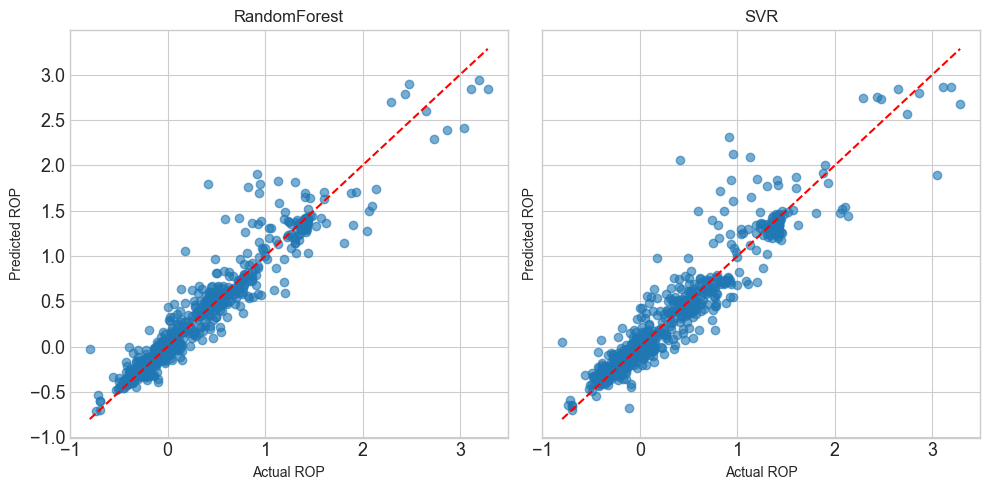

In [37]:
n_models = len(predictions_dict)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5), sharey=True)

for ax, (model_name, y_pred) in zip(axes, predictions_dict.items()):
    ax.scatter(y_test, y_pred, alpha=0.6)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    ax.set_title(model_name)
    ax.set_xlabel("Actual ROP")
    ax.set_ylabel("Predicted ROP")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np

# # Calculate absolute residuals
# abs_residuals = np.abs(y_test - y_pred)

# # Set an anomaly threshold (e.g., mean + 2*std)
# threshold = abs_residuals.mean() + 2 * abs_residuals.std()

# # Flag anomalies
# anomalies = abs_residuals > threshold

# print(f"Threshold for anomalies: {threshold:.3f}")
# print(f"Number of anomalies detected: {anomalies.sum()}")

# # Visualize anomalies
# plt.figure(figsize=(8,6))
# plt.scatter(range(len(abs_residuals)), abs_residuals, c='blue', alpha=0.6, label='Residual')
# plt.scatter(
#     np.where(anomalies)[0], 
#     abs_residuals[anomalies], 
#     c='red', 
#     label='Anomaly'
# )
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
# plt.title("Anomaly Detection via Residuals")
# plt.xlabel("Test Sample Index")
# plt.ylabel("Absolute Residual")
# plt.legend()
# plt.show()


In [38]:
# After grid search is done and 'results' is populated
best_rf_model = None
best_svr_model = None

for model_name, best_est, best_params, best_score in results:
    print("DEBUG: model_name=", repr(model_name))
    if model_name == "RandomForest":
        best_rf_model = best_est
    elif model_name == "SVR":
        best_svr_model = best_est

print("Best RandomForest Model:", best_rf_model)
print("Best SVR Model:", best_svr_model)


DEBUG: model_name= 'RandomForest'
DEBUG: model_name= 'SVR'
Best RandomForest Model: RandomForestRegressor(random_state=42)
Best SVR Model: SVR(C=10, gamma='auto')


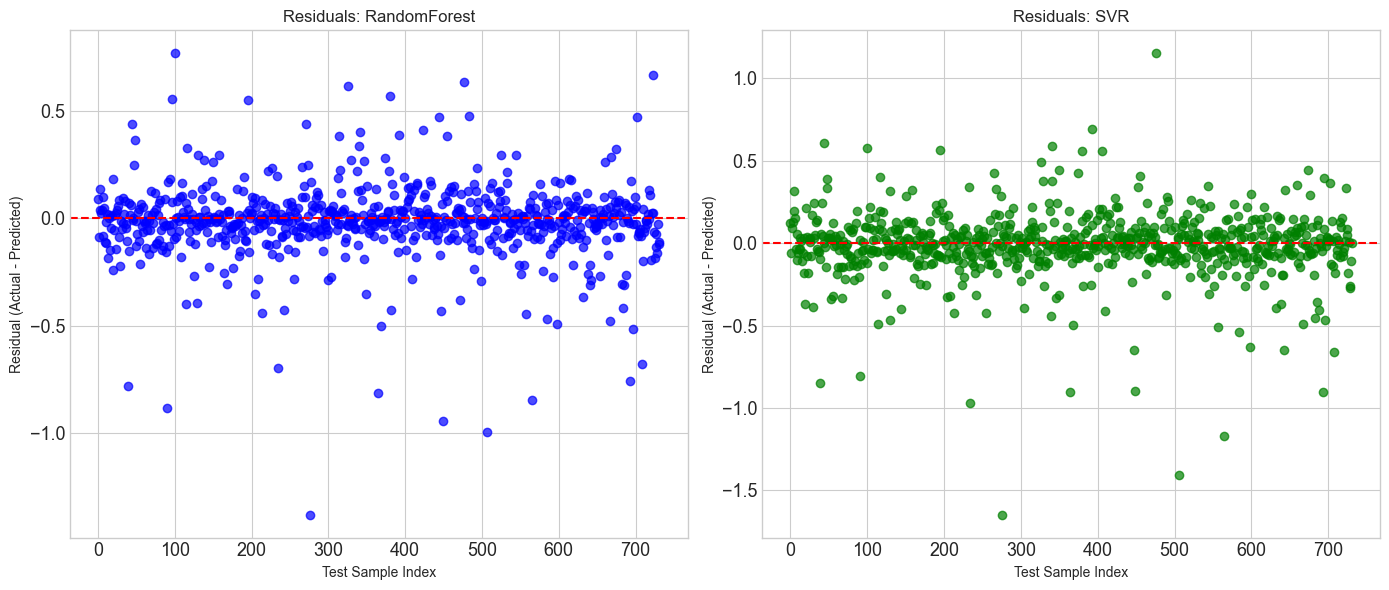

In [39]:


if best_rf_model is None or best_svr_model is None:
    print("Error: One or both best models are not defined.")
else:
    # Predictions
    y_pred_rf = best_rf_model.predict(X_test)
    y_pred_svr = best_svr_model.predict(X_test)

    # Residuals
    residuals_rf = y_test - y_pred_rf
    residuals_svr = y_test - y_pred_svr

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].scatter(range(len(residuals_rf)), residuals_rf, color='blue', alpha=0.7)
    axes[0].axhline(y=0, color='red', linestyle='--')
    axes[0].set_title('Residuals: RandomForest')
    axes[0].set_xlabel('Test Sample Index')
    axes[0].set_ylabel('Residual (Actual - Predicted)')

    axes[1].scatter(range(len(residuals_svr)), residuals_svr, color='green', alpha=0.7)
    axes[1].axhline(y=0, color='red', linestyle='--')
    axes[1].set_title('Residuals: SVR')
    axes[1].set_xlabel('Test Sample Index')
    axes[1].set_ylabel('Residual (Actual - Predicted)')

    plt.tight_layout()
    plt.show()


### ROP vs Depth visualization

C:\Users\hrish\AppData\Local\Temp\ipykernel_42768\2982780624.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


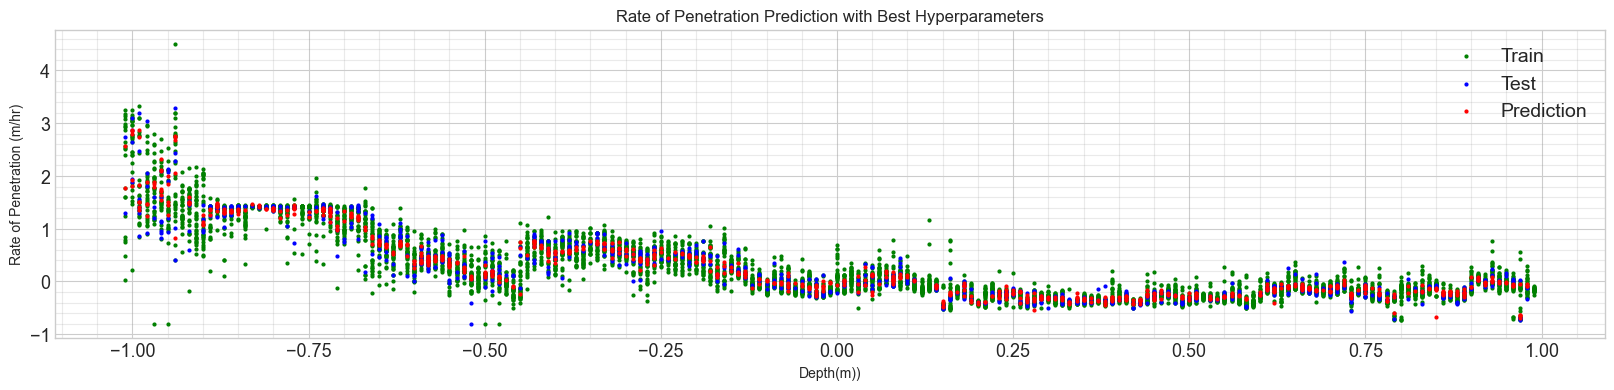

In [42]:
# here:
#   X_train, y_train = training features & target
#   X_test, y_test   = test features & target
#   y_pred           = predictions on X_test from your trained model
#   "Depth(m)"      = column in the DataFrame that indicates depth in feet

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20,4))

# Plot training data (Depth vs. ROP)
ax.scatter(X_train['Depth(m)'], y_train, color='green', s=4, label='Train')

# Plot test data
ax.scatter(X_test['Depth(m)'], y_test, color='blue', s=4, label='Test')

# Plot model predictions
ax.scatter(X_test['Depth(m)'], y_pred, color='red', s=4, label='Prediction')

# Add labels, title, and grid
ax.set_xlabel('Depth(m))')
ax.set_ylabel('Rate of Penetration (m/hr)')
ax.set_title('Rate of Penetration Prediction with Best Hyperparameters')

# Enable minor ticks and set grid style
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# Adjust sizes 
size = 14
plt.rc('axes', titlesize=size)   # default text size
plt.rc('axes', labelsize=size)   # x/y label font size
plt.rc('xtick', labelsize=size)  # x-tick label font size
plt.rc('ytick', labelsize=size)  # y-tick label font size
plt.rc('legend', fontsize=size)  # legend font size
plt.rc('figure', titlesize=size) # figure title font size

plt.legend()
plt.savefig('prediction.pdf', bbox_inches='tight')
plt.show()


In [41]:
df_metric.head()

,Depth(m),ROP(1 m),weight on bit (kg),Temp Out( degC),Temp In(degC),Pit Total (m3),Pump Press (KPa),Hookload (kg),Surface Torque (KPa),Rotary Speed (rpm),Flow In(liters/min),Flow Out %,WH Pressure (KPa),H2S Floor,H2S Cellar,H2S Pits
0,25.96,17.31,0.0,34.16,32.71,43.69,3197.35,14408.16,61.57,151.09,4200.22,101.61,-8485.61,-0.01,-0.03,0.31
1,26.27,18.63,0.0,34.18,32.68,43.69,3168.46,14063.49,61.57,151.09,4195.60,101.70,-8485.61,-0.01,-0.04,0.31
2,26.59,5.66,0.0,34.58,32.73,43.53,3134.26,14063.49,62.12,61.54,4174.82,96.81,-8485.61,-0.01,-0.03,0.30
3,26.90,11.67,0.0,34.69,32.86,43.53,3110.61,14131.52,61.85,60.23,4167.89,96.67,-8485.61,0.00,-0.03,0.31
4,27.24,120.20,0.0,34.71,32.88,43.53,3144.74,14303.85,61.85,61.75,4173.26,96.63,-8485.61,-0.02,-0.02,0.31


In [51]:
df_metric.describe()

,Depth(m),ROP(1 m),weight on bit (kg),Temp Out( degC),Temp In(degC),Pit Total (m3),Pump Press (KPa),Hookload (kg),Surface Torque (KPa),Rotary Speed (rpm),Flow In(liters/min),Flow Out %,WH Pressure (KPa),H2S Floor,H2S Cellar,H2S Pits
count,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000
mean,1168.864378,12.804158,10483.764002,52.255297,47.953090,37.668701,8733.444965,36864.214556,903.132323,54.947292,2711.315497,79.692834,-246.571280,-0.027372,0.004303,0.148833
std,654.527243,23.139621,4135.825227,6.811023,6.629486,2.903400,3382.374016,12019.878472,335.832421,25.947654,536.711275,11.909399,1535.306539,0.042453,0.025282,0.115290
min,25.960000,0.000000,0.000000,28.930000,29.440000,27.170000,137.490000,12367.350000,0.000000,0.000000,0.000000,0.690000,-8493.470000,-0.100000,-0.080000,-0.060000
25%,600.545000,3.470000,8303.850000,46.740000,42.695000,35.700000,4589.240000,24816.330000,806.715000,38.090000,2347.940000,72.650000,20.130000,-0.070000,-0.010000,0.060000
50%,1173.990000,5.480000,10807.260000,51.590000,47.340000,37.860000,9877.500000,36344.670000,967.440000,50.380000,2650.580000,80.710000,40.960000,-0.010000,0.000000,0.140000
75%,1734.710000,13.500000,13460.320000,58.050000,52.700000,39.680000,11512.440000,47904.760000,1084.450000,75.965000,3121.485000,88.845000,56.950000,0.000000,0.020000,0.220000
max,2296.940000,907.620000,21337.870000,66.500000,63.510000,44.500000,15171.960000,67541.950000,1887.230000,271.580000,12558.140000,111.210000,120.040000,0.780000,0.070000,0.720000


In [46]:
# df_metric is the original DataFrame with unscaled data
df_original = df_metric.copy()

In [47]:
# 1. Choose feature columns (unscaled)
feature_cols = [
    'Depth(m)', 'weight on bit (kg)', 'Temp Out( degC)', 'Temp In(degC)',
    'Pit Total (m3)', 'Pump Press (KPa)', 'Hookload (kg)', 'Surface Torque (KPa)',
    'Rotary Speed (rpm)', 'Flow In(liters/min)', 'Flow Out %', 'WH Pressure (KPa)',
    'H2S Floor', 'H2S Cellar', 'H2S Pits'
]

# 2. Create X, y from df_original (unscaled)
X = df_original[feature_cols]
y = df_original['ROP(1 m)']  # unscaled target

# 3. Split into train/test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (6579, 15)
X_test shape: (732, 15)


In [48]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# Let's assume we want to scale everything except Depth(m)
cols_to_scale = [col for col in feature_cols if col != 'Depth(m)']

# Convert to DataFrame for easier manipulation
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit on train, transform train & test
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


In [49]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)  # train with scaled features
y_pred = rf.predict(X_test_scaled)  # predictions for test set


C:\Users\hrish\AppData\Local\Temp\ipykernel_42768\861995169.py:31: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


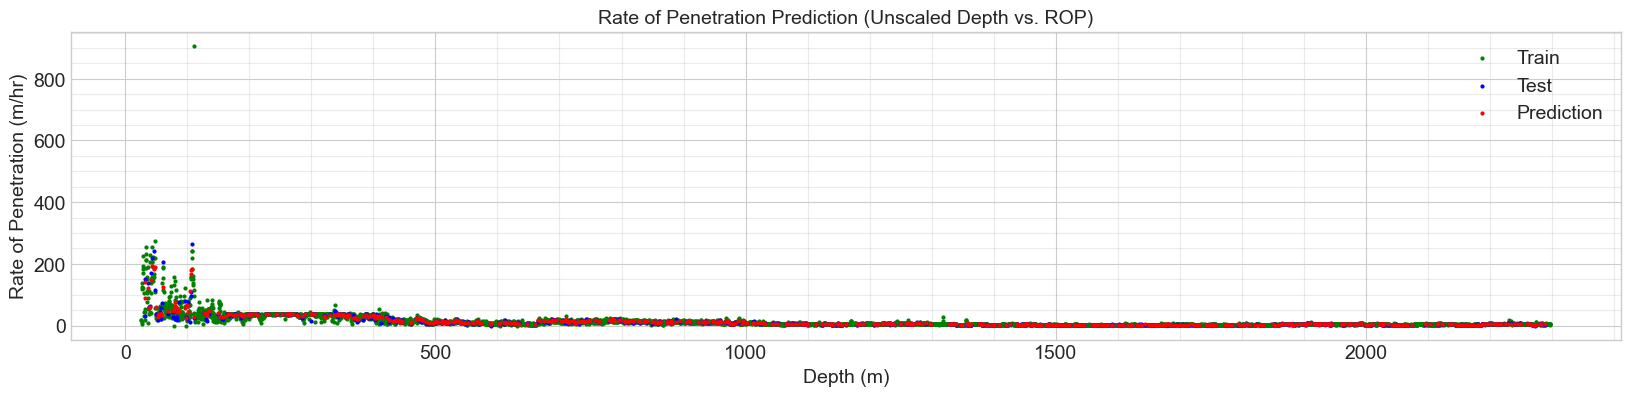

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 4))

# 1. Plot training data (unscaled)
ax.scatter(
    X_train['Depth(m)'],  # unscaled depth
    y_train,              # unscaled ROP
    color='green', s=4, label='Train'
)

# 2. Plot test data (unscaled)
ax.scatter(
    X_test['Depth(m)'],   # unscaled depth
    y_test,               # unscaled ROP
    color='blue', s=4, label='Test'
)

# 3. Plot predictions
ax.scatter(
    X_test['Depth(m)'],   # unscaled depth
    y_pred,               # predicted ROP in original scale
    color='red', s=4, label='Prediction'
)

# 4. Customize labels, title, and grid
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Rate of Penetration (m/hr)')
ax.set_title('Rate of Penetration Prediction (Unscaled Depth vs. ROP)')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend()
plt.show()


### ROP vs Depth (sequential)

In [55]:
# y_pred is a NumPy array of length len(X_test)
# Convert it into a Series that shares X_test's index
y_pred_series = pd.Series(y_pred, index=X_test.index)


In [56]:
# Sort X_test by depth
X_test_sorted = X_test.sort_values(by='Depth(m)')

# Use the same sorted index for y_test and y_pred_series
y_test_sorted = y_test.loc[X_test_sorted.index]
y_pred_sorted = y_pred_series.loc[X_test_sorted.index]


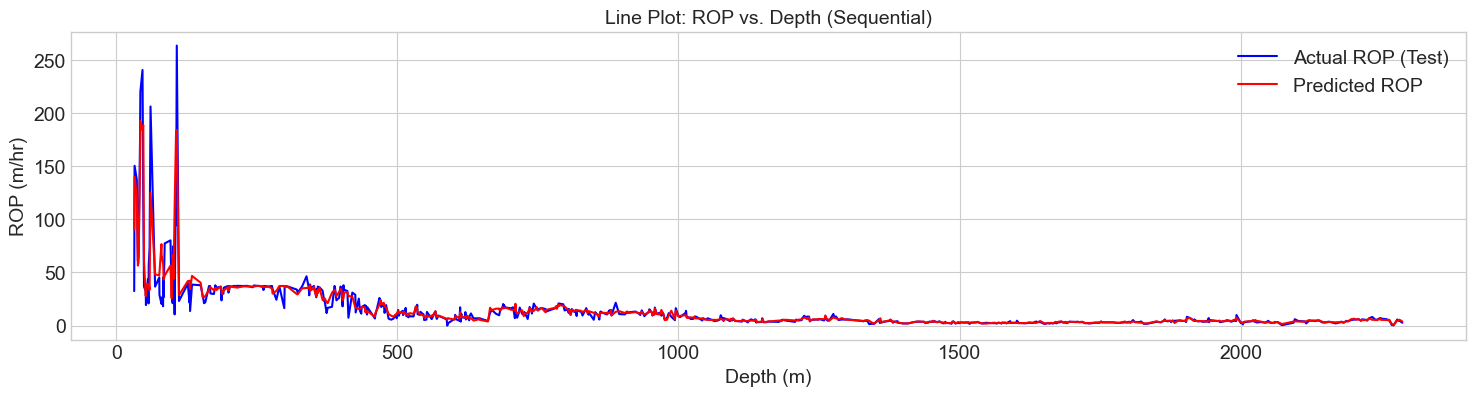

In [59]:
plt.figure(figsize=(18,4))
plt.plot(X_test_sorted['Depth(m)'], y_test_sorted, label='Actual ROP (Test)', color='blue')
plt.plot(X_test_sorted['Depth(m)'], y_pred_sorted, label='Predicted ROP', color='red')
plt.xlabel('Depth (m)')
plt.ylabel('ROP (m/hr)')
plt.title('Line Plot: ROP vs. Depth (Sequential)')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
# # Sort the test set by Depth(m)
# X_test_sorted = X_test.sort_values(by='Depth(m)')

# # Use the same sorted indices for y_test and y_pred
# y_test_sorted = y_test.loc[X_test_sorted.index]
# y_pred_sorted = y_pred[X_test_sorted.index]  # <-- use X_test_sorted.index

# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,4))
# plt.plot(X_test_sorted['Depth(m)'], y_test_sorted, label='Actual ROP (Test)', color='blue')
# plt.plot(X_test_sorted['Depth(m)'], y_pred_sorted, label='Predicted ROP', color='red')
# plt.xlabel('Depth (m)')
# plt.ylabel('ROP (m/hr)')
# plt.title('Line Plot: ROP vs. Depth (Sequential)')
# plt.legend()
# plt.grid(True)
# plt.show()


IndexError: index 733 is out of bounds for axis 0 with size 732

## do not look for below - ignore from here

In [ ]:
# # 1. First, let's check for infinite values and handle them
# def check_and_clean_data(df):
#     # Check for infinite values
#     inf_cols = df.columns[np.isinf(df).any()].tolist()
#     print("Columns with infinite values:", inf_cols)
    
#     # Replace infinite values with NaN
#     df_clean = df.replace([np.inf, -np.inf], np.nan)
    
#     # Handle NaN values by filling with median
#     df_clean = df_clean.fillna(df_clean.median())
    
#     return df_clean

# # 2. Prepare data for LASSO
# X = df_metric.drop('ROP(1 m)', axis=1)
# y = df_metric['ROP(1 m)']

# # 3. Clean the data
# X_cleaned = check_and_clean_data(X)

# # 4. Scale the features before LASSO
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_cleaned)
# X_scaled = pd.DataFrame(X_scaled, columns=X_cleaned.columns)

# # 5. Now apply LASSO for feature selection
# from sklearn.linear_model import Lasso
# from sklearn.feature_selection import SelectFromModel

# lasso = Lasso(alpha=0.01, random_state=42)
# selector = SelectFromModel(lasso, prefit=False)

# # Fit and transform the data
# X_selected = selector.fit_transform(X_scaled, y)

# # Get selected feature names
# selected_features = X_cleaned.columns[selector.get_support()].tolist()

# # Print selected features
# print("\nSelected features:")
# for feature in selected_features:
#     print(f"- {feature}")

# # Print feature importances
# feature_importance = pd.DataFrame({
#     'Feature': X_cleaned.columns,
#     'Importance': np.abs(selector.estimator_.coef_)
# })
# print("\nFeature importances:")
# print(feature_importance.sort_values('Importance', ascending=False))

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping

# # Scale the data
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Build deep learning model
# def build_deep_model(input_dim):
#     model = Sequential([
#         Dense(128, activation='relu', input_dim=input_dim),
#         BatchNormalization(),
#         Dropout(0.3),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(32, activation='relu'),
#         BatchNormalization(),
#         Dense(1)
#     ])
#     return model

# # Train the model
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model = build_deep_model(X_train_scaled.shape[1])
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# history = model.fit(
#     X_train_scaled, y_train,
#     validation_split=0.2,
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stopping],
#     verbose=1
# )

In [ ]:
# from sklearn.ensemble import VotingRegressor
# from sklearn.svm import SVR

# # Create ensemble
# estimators = [
#     ('rf', RandomForestRegressor(n_estimators=200, max_depth=20)),
#     ('svr', SVR(kernel='rbf')),
#     ('dl', model)  # The trained deep learning model
# ]

# ensemble = VotingRegressor(estimators=estimators)
# ensemble.fit(X_train_scaled, y_train)

In [ ]:
# from sklearn.ensemble import VotingRegressor
# from sklearn.svm import SVR
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# import numpy as np

In [ ]:
# # First, create a wrapper class for the Keras model
# from sklearn.base import BaseEstimator, RegressorMixin

# class KerasRegressor(BaseEstimator, RegressorMixin):
#     def __init__(self, model=None):
#         self.model = model

#     def fit(self, X, y):
#         self.model.fit(X, y, epochs=100, batch_size=32, verbose=0)
#         return self

#     def predict(self, X):
#         return self.model.predict(X).flatten()

# # Create and train the deep learning model
# def create_dl_model(input_dim):
#     model = Sequential([
#         Dense(128, activation='relu', input_dim=input_dim),
#         BatchNormalization(),
#         Dropout(0.3),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(32, activation='relu'),
#         BatchNormalization(),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     return model

# # Initialize models
# dl_model = create_dl_model(X_train_scaled.shape[1])
# keras_reg = KerasRegressor(model=dl_model)

# # Create ensemble with wrapped keras model
# estimators = [
#     ('rf', RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)),
#     ('svr', SVR(kernel='rbf')),
#     ('dl', keras_reg)
# ]

# # Create and train ensemble
# ensemble = VotingRegressor(estimators=estimators)
# ensemble.fit(X_train_scaled, y_train)

# # Make predictions and evaluate
# rf_pred = ensemble.named_estimators_['rf'].predict(X_test_scaled)
# svr_pred = ensemble.named_estimators_['svr'].predict(X_test_scaled)
# dl_pred = ensemble.named_estimators_['dl'].predict(X_test_scaled)
# ensemble_pred = ensemble.predict(X_test_scaled)

# # Print results
# print("Model Performance Metrics:")
# print("-" * 50)
# for name, pred in [('Random Forest', rf_pred), 
#                   ('SVR', svr_pred), 
#                   ('Deep Learning', dl_pred),
#                   ('Ensemble', ensemble_pred)]:
#     mae = mean_absolute_error(y_test, pred)
#     rmse = np.sqrt(mean_squared_error(y_test, pred))
#     r2 = r2_score(y_test, pred)
#     print(f"\n{name}:")
#     print(f"MAE: {mae:.3f}")
#     print(f"RMSE: {rmse:.3f}")
#     print(f"R2: {r2:.3f}")

In [ ]:
# def prepare_sample_data(sample_data):
#     """
#     Prepare sample field data for prediction
#     """
#     # Ensure sample data has the same features as training data
#     required_features = [
#         'weight on bit (kg)',
#         'Rotary Speed (rpm)',
#         'Surface Torque (KPa)',
#         'Pump Press (KPa)',
#         'Flow In (lpm)',
#         'TVD (m)',
#         'WOB_RPM',  # Include engineered features if you created them
#         'Torque_RPM',
#         'MSE'
#     ]
    
#     # Check if all required features are present
#     missing_features = set(required_features) - set(sample_data.columns)
#     if missing_features:
#         raise ValueError(f"Missing features: {missing_features}")
    
#     # Apply the same preprocessing steps used during training
#     sample_data_processed = sample_data.copy()
    
#     # Scale the features using the same scaler used in training
#     sample_data_scaled = scaler.transform(sample_data_processed[required_features])
    
#     return sample_data_scaled






# # Example of creating sample field data
# sample_data = pd.DataFrame({
#     'weight on bit (kg)': [15000, 16000, 17000],
#     'Rotary Speed (rpm)': [120, 130, 140],
#     'Surface Torque (KPa)': [25000, 26000, 27000],
#     'Pump Press (KPa)': [20000, 21000, 22000],
#     'Flow In (lpm)': [2200, 2300, 2400],
#     'TVD (m)': [2500, 2600, 2700],
#     'WOB_RPM': [1800000, 2080000, 2380000],
#     'Torque_RPM': [3000000, 3380000, 3780000],
#     'MSE': [250, 260, 270]
# })




